In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import word2vec
import string
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras import regularizers
from nltk.probability import FreqDist
from nltk.util import ngrams
import seaborn as sns

In [109]:
df = pd.read_csv('data_text/cleaned_reviews.csv')
df

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0
...,...,...,...,...
17335,positive,i love this speaker and love can take it anywh...,30,5.0
17336,positive,i use it in my house easy to connect and loud ...,13,4.0
17337,positive,the bass is good and the battery is amazing mu...,41,5.0
17338,positive,love it,2,5.0


In [3]:
ps = PorterStemmer() 

def preprocessing(sentence, lemma=True, stemming=True, tokenize=True, stopword=True):

    sentence = str(sentence).lower()
    sentence = re.sub(f'[{re.escape(string.punctuation)}]', ' ', sentence)
    sentence = re.sub(' +', ' ', sentence)

    if tokenize:
        words = word_tokenize(sentence)
    else:
        words = sentence.split()

    if stopword:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

    if stemming:
        words = [ps.stem(word) for word in words]

    if lemma:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words), words

df['processed_text'] = ""
df['words_list'] = None

for i, row in df.iterrows():
    processed_sentence, words_list = preprocessing(row['cleaned_review'])
    df.at[i, 'processed_text'] = processed_sentence
    df.at[i, 'words_list'] = words_list

In [5]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

tfidf_representation = X_tfidf.toarray()

In [6]:
X = tfidf_representation

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, df.sentiments, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

In [8]:
lg = LogisticRegression(max_iter=6000, 
                        solver='lbfgs', 
                        penalty='l2',
                        C=1,
                        class_weight='balanced')

In [9]:
model = lg.fit(X_train, y_train)

In [10]:
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
f1_micro = f1_score(y_val, y_val_pred, average='micro')
f1_macro = f1_score(y_val, y_val_pred, average='macro')

y_val_proba = model.predict_proba(X_val)
auroc = roc_auc_score(y_val, y_val_proba, multi_class='ovr')

In [11]:
print(f'Validation Accuracy: {val_accuracy}')
print(f'F1 Micro: {f1_micro}')
print(f'F1 Macro: {f1_macro}')
print(f'AUROC: {auroc}')

Validation Accuracy: 0.7773933102652826
F1 Micro: 0.7773933102652826
F1 Macro: 0.7144344758232339
AUROC: 0.9124446741393308


## Neural Network

In [12]:
y_train

8189      neutral
1760     positive
11705     neutral
16030    positive
10118    negative
           ...   
10721    positive
3141     positive
13485    positive
17128    positive
9643      neutral
Name: sentiments, Length: 6936, dtype: object

In [13]:
y_train = y_train.map({'negative': 0, 'positive': 1, 'neutral': 2})
y_val = y_val.map({'negative': 0, 'positive': 1, 'neutral': 2})
y_test = y_test.map({'negative': 0, 'positive': 1, 'neutral': 2})

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    tf.keras.layers.Dense(3, activation='softmax')  
])

/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6260 - loss: 0.8882 - val_accuracy: 0.7804 - val_loss: 0.5718
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8349 - loss: 0.4656 - val_accuracy: 0.8124 - val_loss: 0.5492
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9152 - loss: 0.3431 - val_accuracy: 0.8054 - val_loss: 0.5828
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9433 - loss: 0.2844 - val_accuracy: 0.8123 - val_loss: 0.6099
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9621 - loss: 0.2362 - val_accuracy: 0.8129 - val_loss: 0.6394
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9745 - loss: 0.2144 - val_accuracy: 0.8152 - val_loss: 0.6978
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9806 - loss: 0.1989 - val_accuracy: 0.8126 - val_loss: 0.7458
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9855 - loss: 0.1720 - val_accuracy: 0.

In [17]:
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f'Test Accuracy: {test_acc}')

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8192 - loss: 0.8112  
Test Accuracy: 0.8179065585136414


: 

## Exploratory Analysis

In [43]:
def frequent_ngram(corpus, ngram, n=30):    

    documents = [sentence for sentence in corpus]
    
    n_grams = [list(ngrams(document, ngram)) for document in documents]
    n_grams_flat = [item for sublist in n_grams for item in sublist]

    freq_dist = FreqDist(n_grams_flat)
    top_freq = freq_dist.most_common(n)

    top_freq = [(str(ngram), count) for ngram, count in top_freq]

    return pd.DataFrame(top_freq, columns=["ngram", "count"])

In [48]:
# Most common unigrams
unigrams = frequent_ngram(df['words_list'], 1, 10)
unigrams

,ngram,count
0,"('work',)",7481
1,"('mous',)",6586
2,"('use',)",5664
3,"('great',)",4608
4,"('charg',)",4214
5,"('sound',)",3586
6,"('love',)",3334
7,"('good',)",2985
8,"('like',)",2879
9,"('light',)",2842


In [49]:
# Most frequent bigrams
bigrams = frequent_ngram(df['words_list'], 2, 10)
bigrams

,ngram,count
0,"('stop', 'work')",1116
1,"('sound', 'qualiti')",982
2,"('work', 'great')",886
3,"('batteri', 'life')",660
4,"('work', 'well')",508
5,"('mous', 'work')",495
6,"('great', 'sound')",485
7,"('easi', 'use')",356
8,"('use', 'mous')",339
9,"('hold', 'charg')",325


Text(0.5, 1.0, 'Most common unigrams')

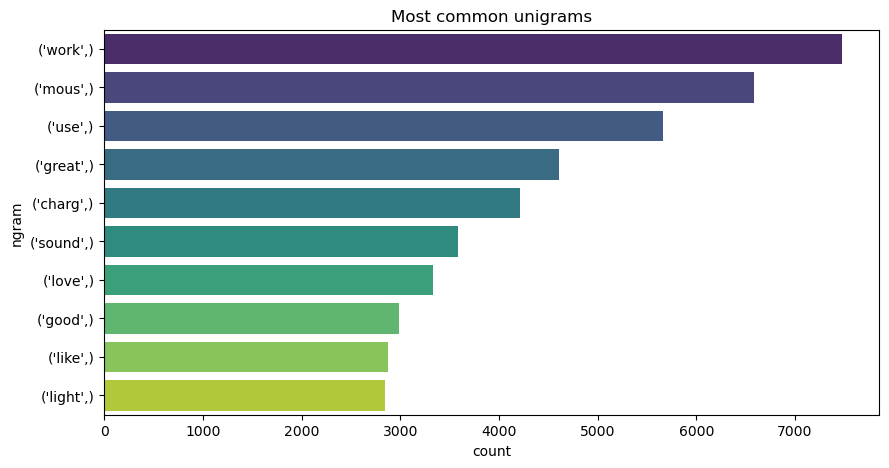

In [64]:
plt.figure(figsize=(10,5))
sns.barplot(x="count", y="ngram", data=unigrams, hue='ngram', palette="viridis")
plt.title("Most common unigrams")

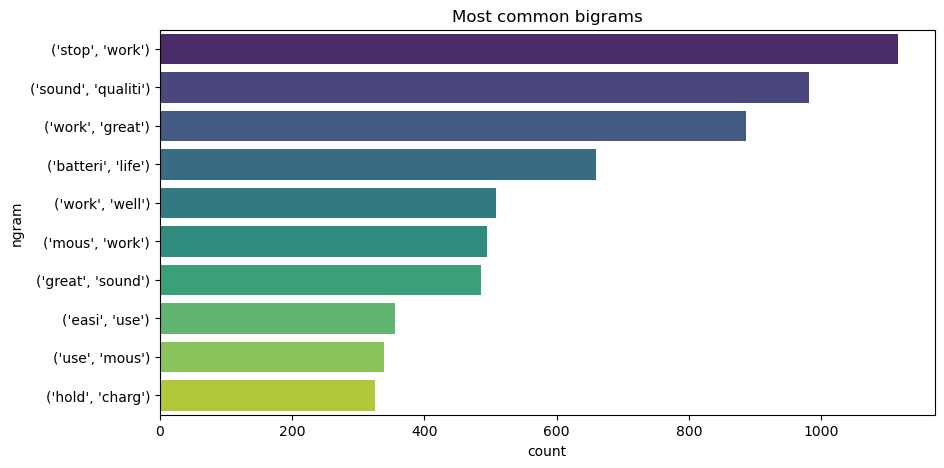

In [63]:
plt.figure(figsize=(10,5))
sns.barplot(x="count", y="ngram", data=bigrams, hue='ngram', palette="viridis")
plt.title("Most common bigrams")
plt.show()

### More Analysis

<Axes: xlabel='sentiments'>

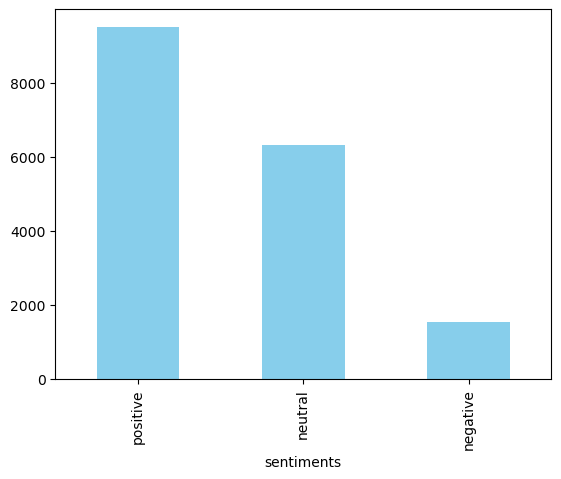

In [68]:
df['sentiments'].value_counts().plot(kind='bar', color='skyblue')

In [69]:
df['review_score'].mean()

3.6490772779700116

<Axes: xlabel='review_score'>

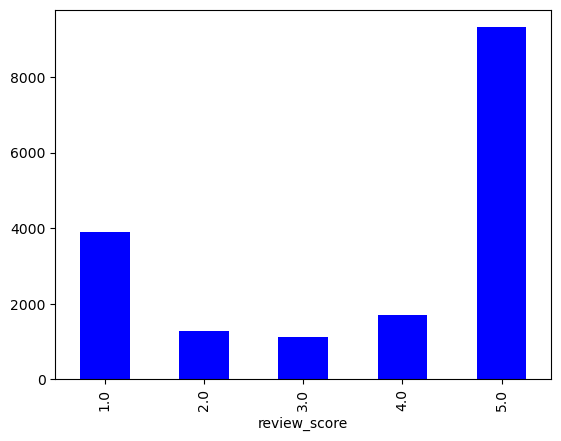

In [77]:
rev_score_cat = df['review_score'].copy()
rev_score_cat = rev_score_cat.astype('category')
rev_score_cat.value_counts(sort=False).plot(kind='bar', color='blue')

In [78]:
df

,sentiments,cleaned_review,cleaned_review_length,review_score,processed_text,words_list
0,positive,i wish would have gotten one earlier love it a...,19,5.0,wish would gotten one earlier love make work l...,"[wish, would, gotten, one, earlier, love, make..."
1,neutral,i ve learned this lesson again open the packag...,88,1.0,learn lesson open packag use product right awa...,"[learn, lesson, open, packag, use, product, ri..."
2,neutral,it is so slow and lags find better option,9,2.0,slow lag find better option,"[slow, lag, find, better, option]"
3,neutral,roller ball stopped working within months of m...,12,1.0,roller ball stop work within month minim use p...,"[roller, ball, stop, work, within, month, mini..."
4,neutral,i like the color and size but it few days out ...,21,1.0,like color size day return period hold charg,"[like, color, size, day, return, period, hold,..."
...,...,...,...,...,...,...
17335,positive,i love this speaker and love can take it anywh...,30,5.0,love speaker love take anywher charg phone wor...,"[love, speaker, love, take, anywher, charg, ph..."
17336,positive,i use it in my house easy to connect and loud ...,13,4.0,use hous easi connect loud clear music,"[use, hous, easi, connect, loud, clear, music]"
17337,positive,the bass is good and the battery is amazing mu...,41,5.0,bass good batteri amaz much better charg thing...,"[bass, good, batteri, amaz, much, better, char..."
17338,positive,love it,2,5.0,love,[love]


### Avg review score per sentiment

In [111]:
avg_scores = df.groupby('sentiments')[['review_score']].mean().reset_index()
avg_scores

,sentiments,review_score
0,negative,3.362451
1,neutral,3.492464
2,positive,3.799221


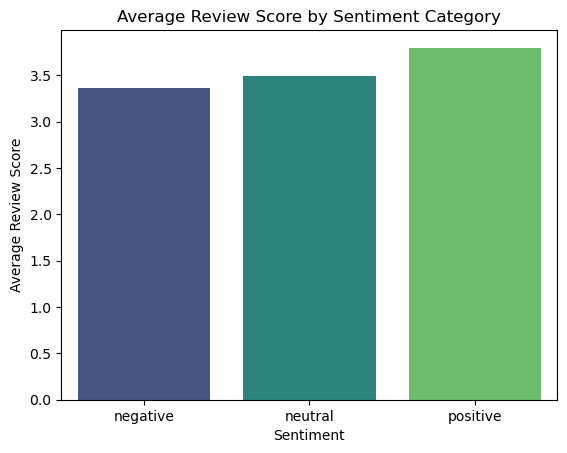

In [113]:
sns.barplot(x='sentiments', y='review_score', data=avg_scores, hue='sentiments', palette='viridis')

plt.title('Average Review Score by Sentiment Category')
plt.xlabel('Sentiment')
plt.ylabel('Average Review Score')
plt.show()

### Avg length per sentiment

In [110]:
avg_length = df.groupby('sentiments')[['cleaned_review_length']].mean().reset_index()
avg_length

,sentiments,cleaned_review_length
0,negative,43.981095
1,neutral,22.823259
2,positive,33.051457


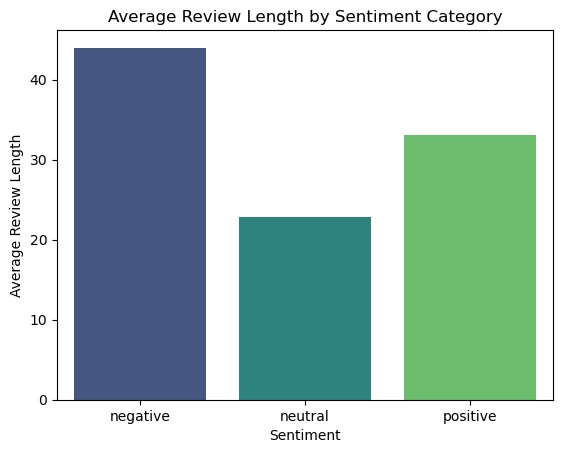

In [115]:
sns.barplot(x='sentiments', y='cleaned_review_length', data=avg_length, hue='sentiments', palette='viridis')

plt.title('Average Review Length by Sentiment Category')
plt.xlabel('Sentiment')
plt.ylabel('Average Review Length')
plt.show()

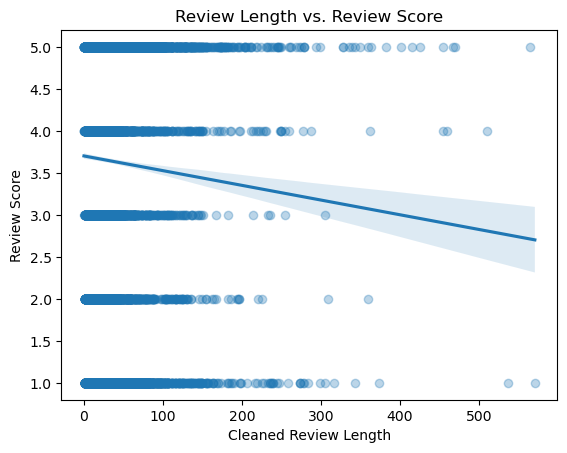

In [86]:
sns.regplot(x='cleaned_review_length', y='review_score', data=df, scatter_kws={'alpha':0.3})

plt.title('Review Length vs. Review Score')
plt.xlabel('Cleaned Review Length')
plt.ylabel('Review Score')
plt.show()

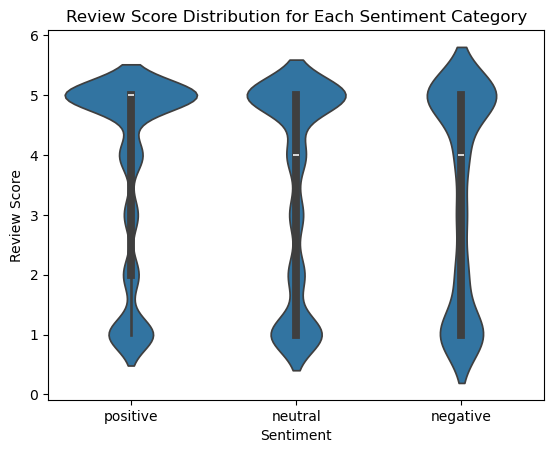

In [88]:
sns.violinplot(x='sentiments', y='review_score', data=df)

plt.title('Review Score Distribution for Each Sentiment Category')
plt.xlabel('Sentiment')
plt.ylabel('Review Score')
plt.show()

<Axes: xlabel='review_score', ylabel='cleaned_review_length'>

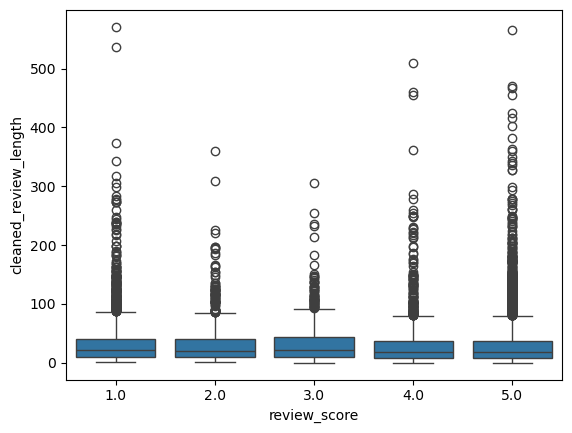

In [84]:
sns.boxplot(x='review_score', y='cleaned_review_length', data=df)